
# MOVRP MOEA Results — Insights & Visualizations

This notebook is placed in **`ROOT/notebooks/`** and reads data from **`../src/results/`**.

**Expected files:**
- `runs_raw.csv` — run rows (metadata).
- `fronts_long.parquet` (preferred) or `fronts_long.csv` — Pareto-front points.
- _Optional:_ `metrics_auto_<preset name>.csv` — per-run GD/IGD/spacing/hypervolume.
- _Optional:_ `summary_metrics.csv` — pre-aggregated summaries.

We validate inputs, then produce runtime tables, Pareto-front plots, and convergence/diversity comparisons.


In [70]:

# %pip install -q pandas pyarrow matplotlib

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths relative to ROOT/notebooks/
DATA_DIR = Path("..") / "src" / "results"

RUNS_FILE = DATA_DIR / "runs_raw.csv"
FRONTS_PQ  = DATA_DIR / "fronts_long.parquet"
FRONTS_CSV = DATA_DIR / "fronts_long.csv"
METRICS_FILE = DATA_DIR / "metrics_auto.csv"
SUMMARY_METRICS_FILE = DATA_DIR / "summary_metrics.csv"

def read_fronts():
    if FRONTS_PQ.exists():
        try:
            return pd.read_parquet(FRONTS_PQ)
        except Exception as e:
            print("Parquet load failed, falling back to CSV:", e)
    return pd.read_csv(FRONTS_CSV)

runs = pd.read_csv(RUNS_FILE)
fronts = read_fronts()
metrics = pd.read_csv(METRICS_FILE) if METRICS_FILE.exists() else None
summary_metrics = pd.read_csv(SUMMARY_METRICS_FILE) if SUMMARY_METRICS_FILE.exists() else None

def read_variant_csvs(dirpath: Path, base: str, tag_col: str = "variant"):
    files = sorted(dirpath.glob(f"{base}*.csv"))
    if not files:
        return None
    frames = []
    for p in files:
        df = pd.read_csv(p)
        # infer variant from stem: e.g. metrics_auto_balanced -> "balanced"
        stem = p.stem  # without .csv
        variant = stem[len(base):].lstrip("_") or "default"
        df[tag_col] = variant
        frames.append(df)
    return pd.concat(frames, ignore_index=True)


# Load ALL variants: metrics_auto_*.csv and summary_metrics_*.csv
metrics = read_variant_csvs(DATA_DIR, "metrics_auto")
summary_metrics = read_variant_csvs(DATA_DIR, "summary_metrics")

def normcols(df):
    df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
    return df

runs_nc   = normcols(runs.copy())
fronts_nc = normcols(fronts.copy())
metrics_nc = normcols(metrics.copy()) if metrics is not None else None
summary_metrics_nc = normcols(summary_metrics.copy()) if summary_metrics is not None else None

print("Loaded:", len(runs_nc), "runs;", len(fronts_nc), "points.")
print("\nColumn headers:")
print("runs_nc:", runs_nc.columns.tolist())
print("fronts_nc:", fronts_nc.columns.tolist())
print("metrics_nc:", metrics_nc.columns.tolist() if metrics_nc is not None else "None")
print("summary_metrics_nc:", summary_metrics_nc.columns.tolist() if summary_metrics_nc is not None else "None")


# Nice-to-have: show which metric variants were detected
if metrics_nc is not None and "variant" in metrics_nc.columns:
    print("metrics variants:", sorted(metrics_nc["variant"].dropna().unique().tolist()))

if summary_metrics_nc is not None and "variant" in summary_metrics_nc.columns:
    print("summary_metrics variants:", sorted(summary_metrics_nc["variant"].dropna().unique().tolist()))


Loaded: 720 runs; 8574 points.

Column headers:
runs_nc: ['instance', 'instance_internal', 'category', 'algorithm', 'preset', 'seed', 'wall_clock_s', 'evaluations', 'gd', 'igd', 'spread', 'hv']
fronts_nc: ['algorithm', 'instance_size', 'instance_name', 'preset', 'seed', 'f1_distance', 'f2_balance_std']
metrics_nc: ['instance', 'algorithm', 'preset', 'seed', 'gd_fixed', 'igd_fixed', 'hv_fixed', 'spread_proxy', 'variant']
summary_metrics_nc: ['instance', 'algorithm', 'preset', 'wall_clock_s_mean', 'wall_clock_s_std', 'evaluations_mean', 'evaluations_std', 'gd_mean', 'gd_std', 'igd_mean', 'igd_std', 'spread_mean', 'spread_std', 'hv_mean', 'hv_std', 'variant']
metrics variants: ['balanced', 'fast', 'thorough']
summary_metrics variants: ['default']


In [71]:
# ---- Key harmonization & diagnostics ----
import re

def _strip_obj(df, cols):
    for c in cols:
        if c in df.columns and df[c].dtype == object:
            df[c] = df[c].astype(str).str.strip()
    return df

# 0) fronts: ensure we have a canonical 'instance'
_fronts = fronts_nc.copy()
if "instance" not in _fronts.columns:
    if "instance_name" in _fronts.columns:
        _fronts = _fronts.rename(columns={"instance_name": "instance"})
    else:
        raise AssertionError("Fronts is missing an 'instance' or 'instance_name' column.")

# 1) Normalize whitespace and coerce comparable dtypes
text_like = ["instance", "preset", "algorithm"]
runs_nc = _strip_obj(runs_nc, text_like + ["instance_internal", "category"])
_fronts  = _strip_obj(_fronts,  text_like)

runs_nc["seed"] = pd.to_numeric(runs_nc["seed"], errors="coerce").astype("Int64")
_fronts["seed"] = pd.to_numeric(_fronts["seed"], errors="coerce").astype("Int64")

assert _fronts.columns.is_unique, "fronts has duplicate column labels"
assert runs_nc.columns.is_unique, "runs has duplicate column labels"

def _canon(text: str) -> str:
    """Lowercase + strip non-alphanumerics to a key like 'nsgaii'."""
    if pd.isna(text):
        return text
    return re.sub(r"[^a-z0-9]+", "", str(text).lower())

# Map from normalized key -> canonical label to use in joins
ALG_MAP = {
    "nsgaii": "nsga-ii",
    "nsga2":  "nsga-ii",
    "nsga_ii":"nsga-ii",
    "nsga-ii":"nsga-ii",
    "moga":   "moga",
    "vega":   "vega",
}
PRESET_MAP = {
    "fast":      "fast",
    "balanced":  "balanced",
    "thorough":  "thorough",
    "default":   "balanced",   # if any default sneaks in from summaries
    "bal":       "balanced",
    "thr":       "thorough",
}

SIZE_MAP = {
    # small
    "s": "small", "sm": "small", "small": "small",
    # medium (catch typos/aliases)
    "m": "medium", "mid": "medium", "medium": "medium", "med": "medium", "meduim": "medium", "normal": "medium",
    # large
    "l": "large", "lg": "large", "large": "large", "big": "large"
}

def _canon_size(s):
    return (
        pd.Series(s, copy=False)
          .astype(str).str.lower().str.strip()
          .map(SIZE_MAP)
          .fillna(pd.Series(s, copy=False).astype(str).str.lower().str.strip())
    )

# Apply to both frames you use downstream
if "instance_size" in _fronts.columns:
    _fronts["instance_size"] = _canon_size(_fronts["instance_size"])

if "category" in runs_nc.columns:
    runs_nc["category"] = _canon_size(runs_nc["category"])

# Quick sanity peek
print("sizes in fronts:", _fronts["instance_size"].value_counts(dropna=False).sort_index().to_dict())
print("sizes in runs  :", runs_nc["category"].value_counts(dropna=False).sort_index().to_dict())

# Apply to BOTH frames in-place so join uses the canonical strings
for df, col, MAP in [
    (runs_nc,   "algorithm", ALG_MAP),
    (_fronts,   "algorithm", ALG_MAP),
    (runs_nc,   "preset",    PRESET_MAP),
    (_fronts,   "preset",    PRESET_MAP),
]:
    key = f"__norm_{col}"
    df[key] = df[col].map(_canon)
    df[col] = df[key].map(MAP).fillna(df[col].str.lower())  # fall back to lowercase original if unmapped
    df.drop(columns=[key], inplace=True)

# Quick peek so you can see what you’ll actually be joining on
print("algorithms (runs):", sorted(runs_nc["algorithm"].dropna().unique().tolist()))
print("algorithms (fronts):", sorted(_fronts["algorithm"].dropna().unique().tolist()))
print("presets (runs):", sorted(runs_nc["preset"].dropna().unique().tolist()))
print("presets (fronts):", sorted(_fronts["preset"].dropna().unique().tolist()))

# 2) Safely test which runs column ('instance' vs 'instance_internal') matches best
KEY_CORE = ["preset", "algorithm", "seed"]

def _prep_runs_for(runs_inst_col: str) -> pd.DataFrame:
    """Return de-duplicated ['instance','preset','algorithm','seed'] from runs,
    sourcing 'instance' from runs_inst_col without creating duplicate labels."""
    if runs_inst_col not in runs_nc.columns:
        return pd.DataFrame(columns=["instance"] + KEY_CORE)
    cols = [runs_inst_col] + [c for c in KEY_CORE if c in runs_nc.columns]
    right = runs_nc.loc[:, cols].drop_duplicates()
    right = right.rename(columns={runs_inst_col: "instance"})
    return right

def match_rate(runs_inst_col: str) -> float:
    left = _fronts.loc[:, ["instance"] + KEY_CORE].drop_duplicates()
    right = _prep_runs_for(runs_inst_col)
    if right.empty:
        return -1.0
    merged = left.merge(right, on=["instance"] + KEY_CORE, how="left", indicator=True)
    ok = (merged["_merge"] == "both").sum()
    return ok / len(left) if len(left) else 0.0

rate_instance          = match_rate("instance")
rate_instance_internal = match_rate("instance_internal")

use_runs_instance_col = "instance" if rate_instance >= rate_instance_internal else "instance_internal"
print(f"[Key test] match(instance)={rate_instance:.3f}  match(instance_internal)={rate_instance_internal:.3f}  → using runs.{use_runs_instance_col}")

# 3) Build keyed runs and recompute orphans
KEY = ["instance"] + KEY_CORE
runs_keyed = _prep_runs_for(use_runs_instance_col)

fronts_join = _fronts.merge(runs_keyed[KEY], on=KEY, how="left", indicator=True)
orphans = fronts_join["_merge"].eq("left_only").sum()

if orphans:
    print(f"Orphans still present: {orphans} rows. Top mismatch patterns:")

    def break_down(col):
        cols = [c for c in KEY if c != col]
        tmp = (_fronts.merge(runs_keyed[cols].drop_duplicates(), on=cols, how="inner")
                      .merge(runs_keyed[KEY].drop_duplicates(), on=KEY, how="left", indicator=True))
        return tmp[tmp["_merge"] == "left_only"][col].value_counts().head(10)

    for col in KEY:
        vc = break_down(col)
        if not vc.empty:
            print(f" - Suspect column '{col}': e.g. {vc.to_dict()}")

    print("[dtype] fronts:", {k: str(_fronts[k].dtype) for k in KEY if k in _fronts})
    print("[dtype] runs  :", {k: str(runs_keyed[k].dtype) for k in runs_keyed})
    sample_orphans = fronts_join[fronts_join["_merge"] == "left_only"][KEY].drop_duplicates().head(5)
    print("Sample orphan keys:\n", sample_orphans.to_string(index=False))

# 4) Enforce: no orphans
assert orphans == 0, f"Orphan points detected in fronts ({orphans} rows without matching run)."

# 5) Seeds grid: 20 seeds per (instance,preset,algorithm); total 36 such cells
seeds = runs_keyed.groupby(["instance", "preset", "algorithm"])["seed"].nunique()
assert seeds.shape[0] == 36, f"Expected 36 cells, got {seeds.shape[0]}"
assert (seeds == 20).all(), "Some (instance,preset,algorithm) cells do not have exactly 20 seeds."

# 6) Every run should have ≥1 front point
front_counts = _fronts.groupby(["instance", "preset", "algorithm", "seed"]).size()
missing_fronts_runs = (
    runs_keyed.set_index(["instance", "preset", "algorithm", "seed"])
              .index.difference(front_counts.index)
)
assert len(missing_fronts_runs) == 0, f"{len(missing_fronts_runs)} runs have no fronts points."

print("Integrity checks: OK ✓")


sizes in fronts: {'large': 2540, 'medium': 1313, 'small': 4721}
sizes in runs  : {'large': 240, 'medium': 240, 'small': 240}
algorithms (runs): ['nsga-ii', 'vega']
algorithms (fronts): ['nsga-ii', 'vega']
presets (runs): ['balanced', 'fast', 'thorough']
presets (fronts): ['balanced', 'fast', 'thorough']
[Key test] match(instance)=1.000  match(instance_internal)=0.000  → using runs.instance
Integrity checks: OK ✓


In [72]:
# ---- Runtime & evaluations summary ----
KEY_ALL = ["instance","algorithm","preset","seed"]

# 1) Count #points per run from fronts
front_counts = (
    _fronts
    .groupby(KEY_ALL, as_index=False)
    .size()
    .rename(columns={"size": "front_size"})
)

# 2) Join counts back to runs (so we have wall_clock_s, evaluations + front_size)
runs_w_front = runs_nc.merge(front_counts, on=KEY_ALL, how="left")

# If you kept the earlier invariant "every run has ≥1 front point", this should be true:
assert runs_w_front["front_size"].notna().all(), "Some runs have no fronts; expected ≥1."
runs_w_front["front_size"] = runs_w_front["front_size"].astype(int)

# 3) Aggregate
runtime_summary = (
    runs_w_front
    .groupby(["instance","algorithm","preset"], as_index=False)
    .agg(
        wall_clock_s_mean   = ("wall_clock_s","mean"),
        wall_clock_s_median = ("wall_clock_s","median"),
        evaluations_mean    = ("evaluations","mean"),
        evaluations_median  = ("evaluations","median"),
        front_size_mean     = ("front_size","mean"),
        front_size_median   = ("front_size","median"),
        runs                = ("seed","nunique"),
    )
    .sort_values(["instance","algorithm","preset"])
)

# (nice-to-have) sanity: total front points equals sum of front_size
assert front_counts["front_size"].sum() == len(_fronts), "Sum(front_size) != number of front rows"

runtime_summary


,instance,algorithm,preset,wall_clock_s_mean,wall_clock_s_median,evaluations_mean,evaluations_median,front_size_mean,front_size_median,runs
0,A-n32-k5,nsga-ii,balanced,9.483763,9.486821,16170.80,16180.0,38.70,42.0,20
1,A-n32-k5,nsga-ii,fast,9.398899,9.400971,16155.00,16134.0,46.10,49.0,20
2,A-n32-k5,nsga-ii,thorough,9.515314,9.469545,16084.50,16103.0,36.10,37.0,20
3,A-n32-k5,vega,balanced,9.628640,9.639080,16686.65,16682.0,5.10,5.0,20
4,A-n32-k5,vega,fast,9.632527,9.601326,16667.90,16665.0,4.35,4.0,20
5,A-n32-k5,vega,thorough,9.623391,9.646835,16689.30,16676.5,4.90,5.0,20
6,A-n36-k5,nsga-ii,balanced,9.358449,9.332623,16270.70,16228.5,29.40,26.0,20
7,A-n36-k5,nsga-ii,fast,9.833667,9.566748,16247.40,16264.5,28.60,28.0,20
8,A-n36-k5,nsga-ii,thorough,9.533851,9.522014,16249.60,16273.0,29.40,32.0,20
9,A-n36-k5,vega,balanced,9.479978,9.473595,16699.65,16703.5,4.10,3.5,20


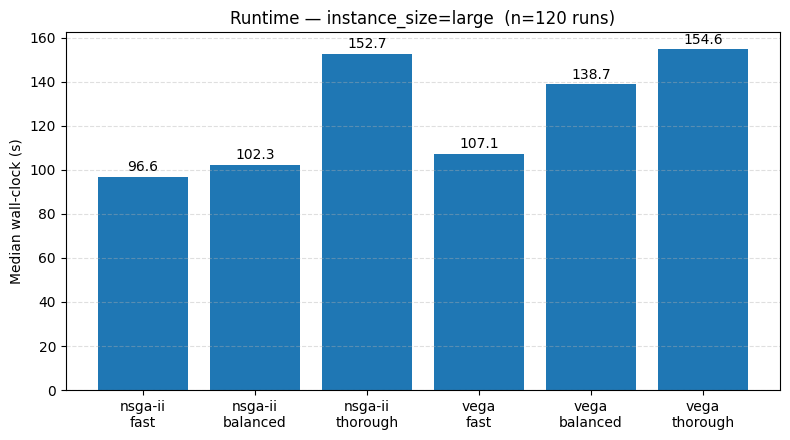

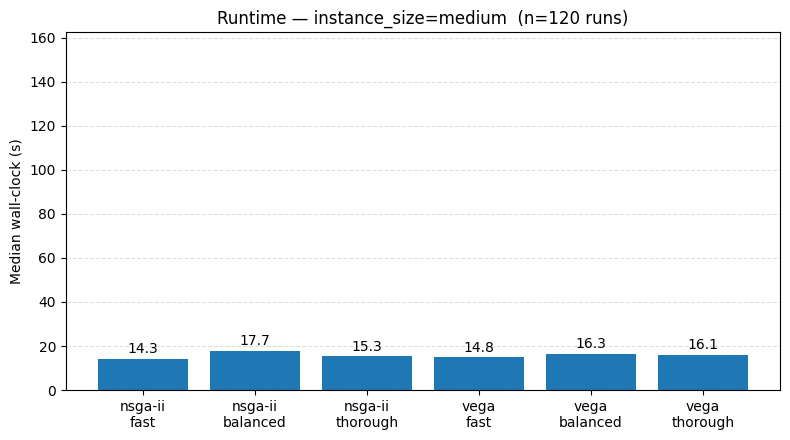

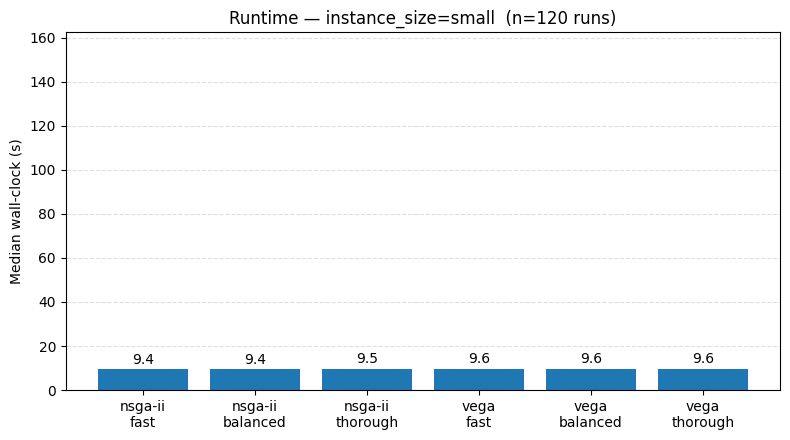

In [73]:

# ---- Aggregate by instance_size (not per instance) ----

# 0) Map instance -> instance_size from _fronts, then attach to runs_w_front
inst_size_map = _fronts[["instance", "instance_size"]].drop_duplicates()
runs_w_size = runs_w_front.merge(inst_size_map, on="instance", how="left")

# sanity: every run should have a size now
missing_sz = runs_w_size["instance_size"].isna().sum()
assert missing_sz == 0, f"{missing_sz} runs missing instance_size mapping."

# 1) Compute size-level summaries directly from runs (true medians)
size_summary = (
    runs_w_size
    .groupby(["instance_size", "algorithm", "preset"], as_index=False)
    .agg(
        wall_clock_s_median = ("wall_clock_s", "median"),
        wall_clock_s_mean   = ("wall_clock_s", "mean"),
        evaluations_median  = ("evaluations", "median"),
        runs                = ("seed", "nunique"),
    )
)

# ---- Plot: median runtime by algorithm/preset for each instance_size ----

alg_order    = ["nsga-ii", "moga", "vega"]   # adjust if needed
preset_order = ["fast", "balanced", "thorough"]
USE_LOG = False  # set True if scales vary a lot

# make a consistent y-limit across sizes
global_max = size_summary["wall_clock_s_median"].max()

# sort sizes numerically if possible
def _as_num(x):
    try:
        return float(x)
    except Exception:
        return x

for sz in sorted(size_summary["instance_size"].unique(), key=_as_num):
    sub = size_summary[size_summary["instance_size"] == sz].copy()
    if sub.empty:
        continue

    # enforce consistent order
    present_algs = [a for a in alg_order if a in sub["algorithm"].unique()]
    present_pre  = [p for p in preset_order if p in sub["preset"].unique()]
    sub["algorithm"] = pd.Categorical(sub["algorithm"], categories=present_algs, ordered=True)
    sub["preset"]    = pd.Categorical(sub["preset"],    categories=present_pre,  ordered=True)
    sub = sub.sort_values(["algorithm", "preset"])

    labels = [f"{a}\n{p}" for a, p in zip(sub["algorithm"].astype(str), sub["preset"].astype(str))]

    fig, ax = plt.subplots(figsize=(8, 4.5))
    x = np.arange(len(sub))
    bars = ax.bar(x, sub["wall_clock_s_median"].to_numpy())

    ax.set_xticks(x, labels)
    ax.set_ylabel("Median wall-clock (s)")
    ax.set_title(f"Runtime — instance_size={sz}  (n={int(sub['runs'].sum())} runs)")
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    if USE_LOG:
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, global_max * 1.05)

    if len(sub) <= 12:
        ax.bar_label(bars, fmt="%.1f", padding=2)

    plt.tight_layout()
    plt.show()



In [74]:
# ---- Clean Pareto fronts: remove sentinel/absurd values + robust outliers ----
import pandas as pd

def _coerce_num(s, comma_decimal=False):
    s = s.astype(str).str.strip()
    if comma_decimal:
        s = s.str.replace(",", ".", regex=False)
    s = s.apply(lambda t: re.sub(r"[^0-9.\-+eE]", "", t))
    return pd.to_numeric(s, errors="coerce")

def clean_fronts(df: pd.DataFrame,
                 fcols=("f1_distance","f2_balance_std"),
                 sentinel_equals=(1e9, 1e12),       # exact sentinel values to drop
                 sentinel_ge=1e8,                   # anything >= this is dropped
                 iqr_k=3.0                          # robust IQR fence per group
                ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Return (clean_df, report) with counts removed by reason & group."""
    f1, f2 = fcols
    gcols = ["instance_size","preset","algorithm"]

    x = df.copy()

    # 1) Numeric
    x[f1] = _coerce_num(x[f1], comma_decimal=False)
    x[f2] = _coerce_num(x[f2], comma_decimal=False)

    # 2) Flag removal reasons
    reasons = {
        "nan":      x[f1].isna() | x[f2].isna(),
        "inf":      ~np.isfinite(x[f1]) | ~np.isfinite(x[f2]),
        "sentinel_eq": False,
        "sentinel_ge": (x[f1].abs() >= sentinel_ge) | (x[f2].abs() >= sentinel_ge),
    }
    # exact sentinel matches (like 1e9)
    if sentinel_equals:
        mask_eq = False
        for val in sentinel_equals:
            mask_eq = mask_eq | (x[f1] == val) | (x[f2] == val)
        reasons["sentinel_eq"] = mask_eq

    # 3) Build initial keep mask
    rm_mask = reasons["nan"] | reasons["inf"] | reasons["sentinel_eq"] | reasons["sentinel_ge"]
    x["_removed_stage"] = np.where(rm_mask, "sentinel/nan/inf", "keep")

    # 4) Robust IQR per group on remaining rows
    keep = x["_removed_stage"].eq("keep")
    def iqr_bounds(s):
        q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3 - q1
        lo = q1 - iqr_k*iqr; hi = q3 + iqr_k*iqr
        return lo, hi

    # compute bounds per group for both metrics
    bounds = []
    for keys, grp in x.loc[keep, gcols + [f1, f2]].groupby(gcols, dropna=False):
        lo1, hi1 = iqr_bounds(grp[f1]); lo2, hi2 = iqr_bounds(grp[f2])
        bounds.append((*keys, lo1, hi1, lo2, hi2))
    bdf = pd.DataFrame(bounds, columns=gcols + [f"{f1}_lo", f"{f1}_hi", f"{f2}_lo", f"{f2}_hi"])

    x = x.merge(bdf, on=gcols, how="left")
    iqr_out = (
        keep
        & (
            (x[f1] < x[f"{f1}_lo"]) | (x[f1] > x[f"{f1}_hi"])
            | (x[f2] < x[f"{f2}_lo"]) | (x[f2] > x[f"{f2}_hi"])
        )
    )
    x.loc[iqr_out, "_removed_stage"] = "iqr_outlier"

    # 5) Report (after marking removals)
    rep = (
        x.groupby(gcols + ["_removed_stage"], dropna=False)
         .size().rename("rows").reset_index()
         .pivot_table(index=gcols, columns="_removed_stage", values="rows", fill_value=0)
         .reset_index()
    )

    # Sum only numeric columns to get a total removed/kept count per group
    num_cols = rep.select_dtypes(include="number").columns
    rep["total"] = rep[num_cols].sum(axis=1)

    # 6) Return cleaned (drop helper bound columns & stage flag)
    drop_cols = [c for c in x.columns if c.endswith("_lo") or c.endswith("_hi")] + ["_removed_stage"]
    cleaned = x[x["_removed_stage"].eq("keep")].drop(columns=drop_cols, errors="ignore")
    return cleaned, rep

# Run cleaning
fronts_clean, clean_report = clean_fronts(_fronts,
                                          fcols=("f1_distance","f2_balance_std"),
                                          sentinel_equals=(1e9,),
                                          sentinel_ge=1e8,
                                          iqr_k=3.0)

print("\n=== Cleaning report by size/preset/algorithm ===")
print(clean_report.to_string(index=False))

# Quick before/after for medium/fast
bf = _fronts[_fronts["instance_size"].str.lower()=="medium"].shape[0]
af = fronts_clean[fronts_clean["instance_size"].str.lower()=="medium"].shape[0]
print(f"\nMedium rows before: {bf:,}  after cleaning: {af:,}")




=== Cleaning report by size/preset/algorithm ===
instance_size   preset algorithm  iqr_outlier   keep  sentinel/nan/inf  total
        large balanced   nsga-ii          2.0  653.0               0.0  655.0
        large balanced      vega          0.0  168.0               0.0  168.0
        large     fast   nsga-ii          7.0  645.0               0.0  652.0
        large     fast      vega          1.0  150.0               0.0  151.0
        large thorough   nsga-ii          0.0  775.0               0.0  775.0
        large thorough      vega          1.0  138.0               0.0  139.0
       medium balanced   nsga-ii          3.0  350.0              20.0  373.0
       medium balanced      vega          0.0    0.0              40.0   40.0
       medium     fast   nsga-ii          0.0  319.0              20.0  339.0
       medium     fast      vega          0.0    7.0              33.0   40.0
       medium thorough   nsga-ii         12.0  450.0              18.0  480.0
       medium 

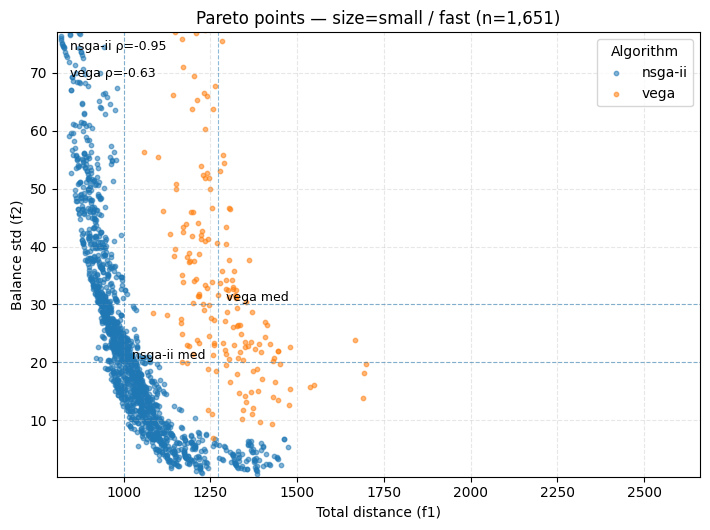

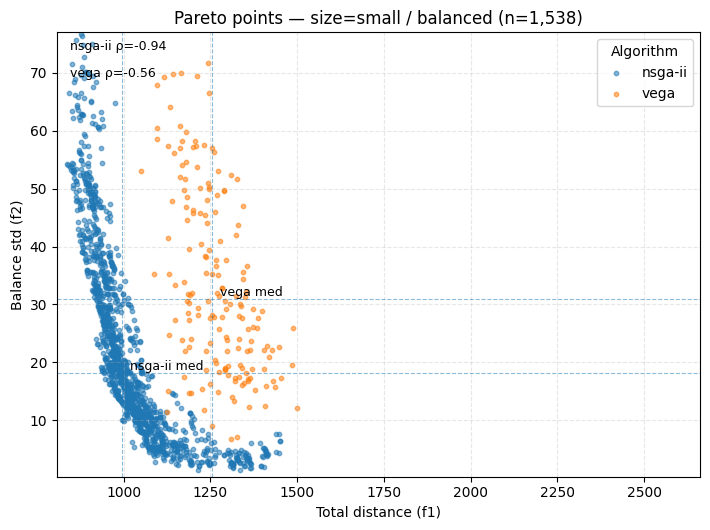

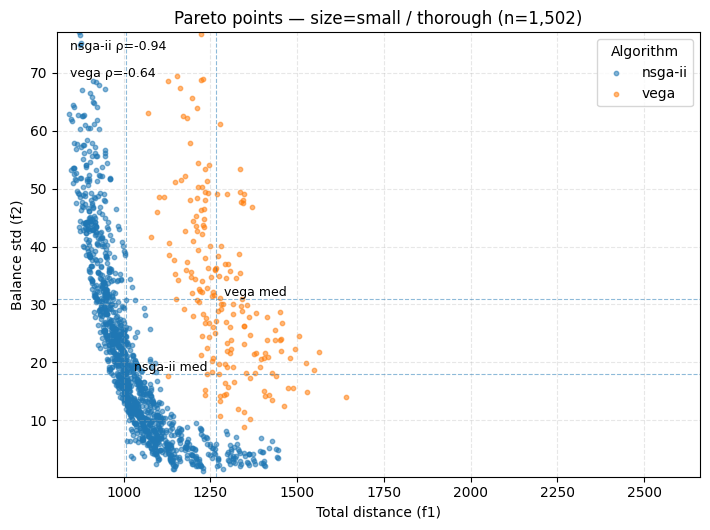

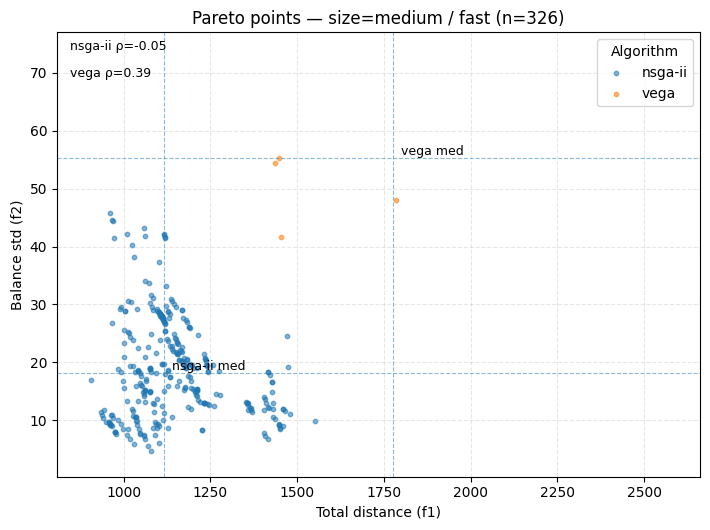

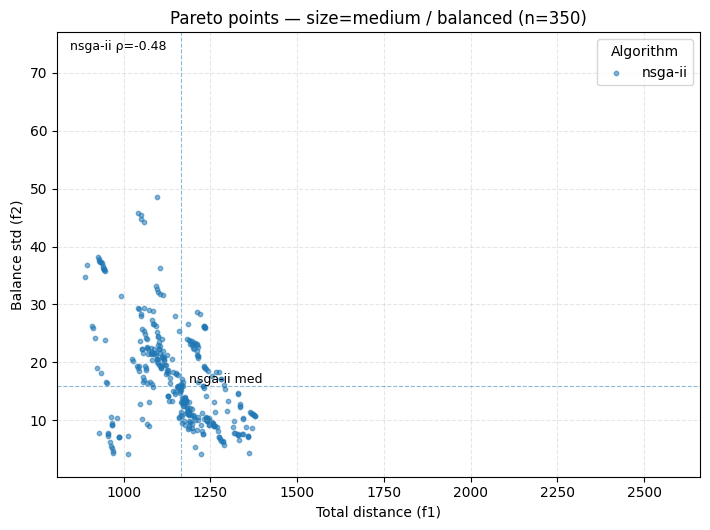

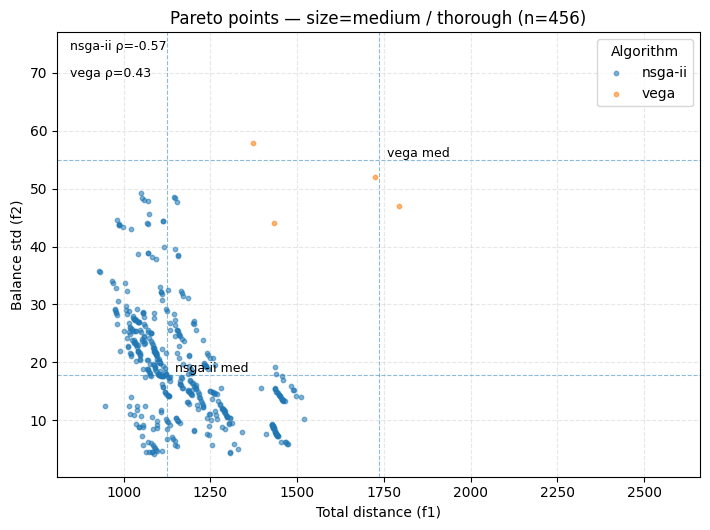

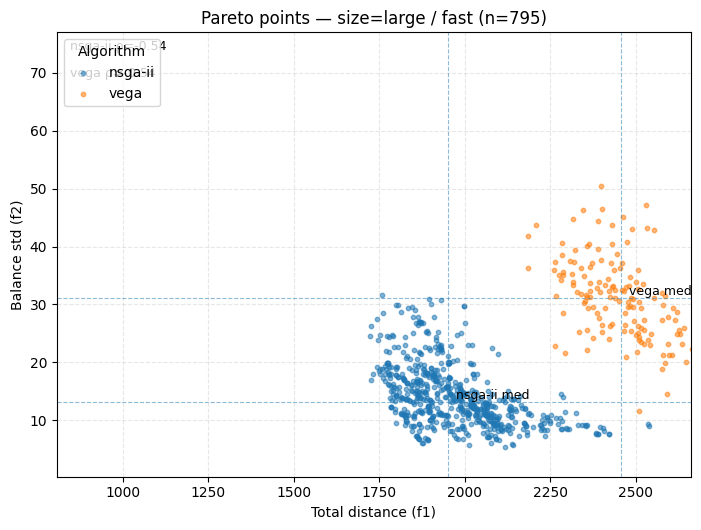

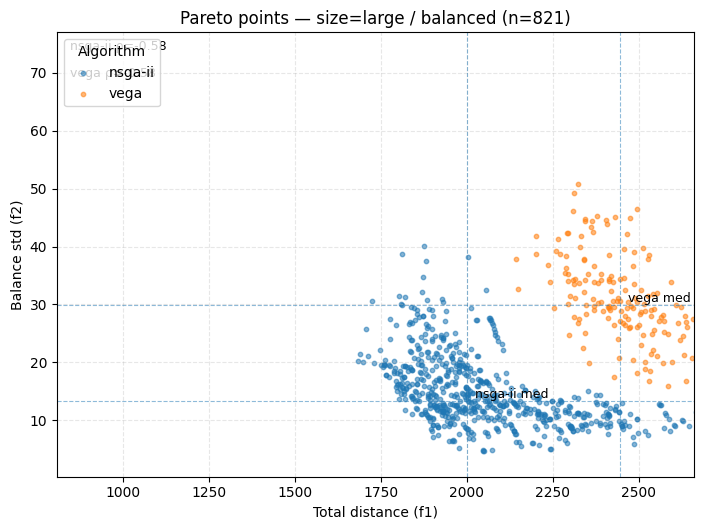

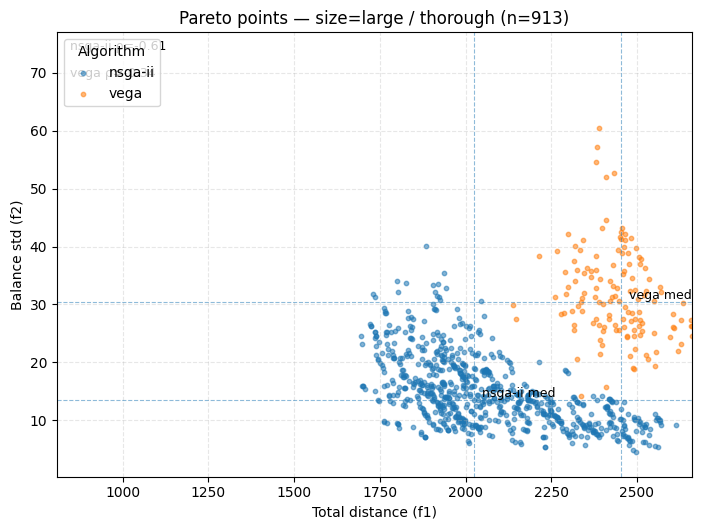

In [75]:
# ---- Enhanced Pareto scatter with medians, global limits, rho, and file export ----

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr  # if not available, comment the rho parts

fronts_plot = fronts_clean.copy()
for col in ["instance_size","preset","algorithm"]:
    fronts_plot[col] = fronts_plot[col].astype(str).str.strip().str.lower()

preferred_sizes   = ["small","medium","large"]
preferred_presets = ["fast","balanced","thorough"]

present_sizes = [s for s in preferred_sizes if s in fronts_plot["instance_size"].unique()]
present_pres  = [p for p in preferred_presets if p in fronts_plot["preset"].unique()]

# 1) Global axis limits for comparability (toggleable)
USE_GLOBAL_LIMITS = True
if USE_GLOBAL_LIMITS:
    f1min, f1max = np.nanpercentile(fronts_plot["f1_distance"], [1, 99])
    f2min, f2max = np.nanpercentile(fronts_plot["f2_balance_std"], [1, 99])
    pad1 = 0.03 * (f1max - f1min)
    pad2 = 0.03 * (f2max - f2min)
    f1min, f1max = f1min - pad1, f1max + pad1
    f2min, f2max = f2min - pad2, f2max + pad2

OUTDIR = Path("figs_fronts"); OUTDIR.mkdir(exist_ok=True)

total_plots = 0
for sz in present_sizes:
    for preset in present_pres:
        sub = fronts_plot[(fronts_plot["instance_size"]==sz) & (fronts_plot["preset"]==preset)]
        if sub.empty:
            continue

        fig, ax = plt.subplots(figsize=(7.2, 5.4))
        # scatter per algorithm
        for algo in sorted(sub["algorithm"].unique()):
            ss = sub[sub["algorithm"]==algo]
            ax.scatter(ss["f1_distance"].to_numpy(),
                       ss["f2_balance_std"].to_numpy(),
                       s=10, alpha=0.55, label=algo)

            # median crosshair + label
            m1 = np.median(ss["f1_distance"])
            m2 = np.median(ss["f2_balance_std"])
            ax.axvline(m1, ls="--", lw=0.8, alpha=0.5)
            ax.axhline(m2, ls="--", lw=0.8, alpha=0.5)
            ax.text(m1, m2, f"  {algo} med", va="bottom", fontsize=9)

            # Spearman rho (optional)
            try:
                rho, _ = spearmanr(ss["f1_distance"], ss["f2_balance_std"])
                ax.text(0.02, 0.96 - 0.06*list(sorted(sub["algorithm"].unique())).index(algo),
                        f"{algo} ρ={rho:0.2f}", transform=ax.transAxes, fontsize=9)
            except Exception:
                pass

        ax.set_xlabel("Total distance (f1)")
        ax.set_ylabel("Balance std (f2)")
        ax.set_title(f"Pareto points — size={sz} / {preset} (n={len(sub):,})")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.legend(title="Algorithm", frameon=True)

        if USE_GLOBAL_LIMITS:
            ax.set_xlim(f1min, f1max)
            ax.set_ylim(f2min, f2max)

        plt.tight_layout()
        # 2) Save figure
        fname = OUTDIR / f"fronts_scatter_size-{sz}_preset-{preset}.png"
        plt.savefig(fname, dpi=160)
        plt.show()

        total_plots += 1




## Convergence & Diversity comparisons
Here we compare algorithms using GD/IGD/spacing (and hypervolume if provided), per preset.


In [76]:
import pandas as pd
import re

def _num_coerce(s, comma_decimal=False):
    s = s.astype(str).str.strip()
    if comma_decimal:
        s = s.str.replace(",", ".", regex=False)
    s = s.apply(lambda t: re.sub(r"[^0-9.\-+eE]", "", t))
    return pd.to_numeric(s, errors="coerce")

def clean_metrics(metrics_in: pd.DataFrame,
                  fronts_map: pd.DataFrame,
                  metric_cols=None,
                  sentinel_equals=(1e9,),
                  sentinel_ge=1e8,
                  iqr_k=3.0):
    """
    Clean metrics: numeric coercion, sentinel removal, robust IQR per (size,preset,algo).
    Returns (metrics_clean, report DataFrame).
    """
    if metrics_in is None or metrics_in.empty:
        return metrics_in, pd.DataFrame()

    # Canonicalize & attach instance_size
    m = metrics_in.copy()
    for col, MAP in (("algorithm", ALG_MAP), ("preset", PRESET_MAP)):
        key = f"__norm_{col}"
        m[key] = m[col].astype(str).str.lower().str.strip().str.replace(r"[^a-z0-9\-]+","", regex=True)
        m[col]  = m[key].map(MAP).fillna(m[col].astype(str).str.lower().str.strip())
        m.drop(columns=[key], inplace=True)

    size_map = fronts_map[["instance","instance_size"]].drop_duplicates()
    m = m.merge(size_map, on="instance", how="left")

    # which metric columns to process
    if metric_cols is None:
        candidates = ["gd_fixed","igd_fixed","hv_fixed","spread_proxy","spacing","hypervolume"]
        metric_cols = [c for c in candidates if c in m.columns]

    # numeric coercion
    for c in metric_cols:
        m[c] = _num_coerce(m[c], comma_decimal=False)

    # group keys
    gcols = ["instance_size","preset","algorithm"]

    # build removal masks
    rm = pd.Series(False, index=m.index)
    reasons = {}

    # NaN/inf
    naninf = pd.Series(False, index=m.index)
    for c in metric_cols:
        naninf |= m[c].isna() | ~np.isfinite(m[c])
    reasons["nan/inf"] = naninf
    rm |= naninf

    # exact sentinels
    eq_mask = pd.Series(False, index=m.index)
    for val in (sentinel_equals or ()):
        for c in metric_cols:
            eq_mask |= (m[c] == val)
    reasons["sentinel_eq"] = eq_mask
    rm |= eq_mask

    # absurdly large values
    if sentinel_ge is not None:
        ge_mask = pd.Series(False, index=m.index)
        for c in metric_cols:
            ge_mask |= (m[c].abs() >= sentinel_ge)
        reasons["sentinel_ge"] = ge_mask
        rm |= ge_mask
    else:
        reasons["sentinel_ge"] = pd.Series(False, index=m.index)

    m["_stage"] = np.where(rm, "sentinel/nan/inf", "keep")

    # IQR filter per group (on each metric; drop row if any metric is out of bounds)
    keep_idx = m["_stage"].eq("keep")
    if keep_idx.any() and iqr_k is not None:
        out_any = pd.Series(False, index=m.index)
        for keys, idx in m[keep_idx].groupby(gcols, dropna=False).groups.items():
            subset = m.loc[idx, metric_cols]
            # bounds per column
            lo = subset.quantile(0.25) - iqr_k*(subset.quantile(0.75) - subset.quantile(0.25))
            hi = subset.quantile(0.75) + iqr_k*(subset.quantile(0.75) - subset.quantile(0.25))
            out = ((subset < lo) | (subset > hi)).any(axis=1)
            out_any.loc[idx] = out_any.loc[idx] | out
        m.loc[out_any, "_stage"] = "iqr_outlier"

    # report
    rep = (
        m.groupby(gcols + ["_stage"], dropna=False).size()
         .rename("rows").reset_index()
         .pivot_table(index=gcols, columns="_stage", values="rows", fill_value=0)
         .reset_index()
    )
    num_cols = rep.select_dtypes(include="number").columns
    rep["total"] = rep[num_cols].sum(axis=1)

    # final clean
    metrics_clean = m[m["_stage"].eq("keep")].drop(columns=["_stage"])
    return metrics_clean, rep

metrics_clean, metrics_clean_report = clean_metrics(
    metrics_nc,           # your stacked metrics with variants
    _fronts,              # for instance_size mapping
    metric_cols=None,     # auto-detect known metric cols
    sentinel_equals=(1e9,),
    sentinel_ge=1e8,      # set to None if you only want to drop exact 1e9
    iqr_k=3.0
)

print("\n=== Metrics cleaning report (per size/preset/algorithm) ===")
print(metrics_clean_report.to_string(index=False))

# Quick sanity: compare row counts
print(f"\nmetrics rows before: {len(metrics_nc):,}  after: {len(metrics_clean):,}")


=== Metrics cleaning report (per size/preset/algorithm) ===
instance_size   preset algorithm  iqr_outlier  keep  total
        large balanced   nsga-ii          0.0  40.0   40.0
        large balanced      vega          0.0  35.0   35.0
        large     fast   nsga-ii          1.0  39.0   40.0
        large     fast      vega          2.0  29.0   31.0
        large thorough   nsga-ii          2.0  38.0   40.0
        large thorough      vega          1.0  27.0   28.0
       medium balanced   nsga-ii          0.0  20.0   20.0
       medium     fast   nsga-ii          0.0  19.0   19.0
       medium thorough   nsga-ii          0.0  20.0   20.0
        small balanced   nsga-ii          0.0  40.0   40.0
        small balanced      vega          0.0  32.0   32.0
        small     fast   nsga-ii          0.0  40.0   40.0
        small     fast      vega          1.0  35.0   36.0
        small thorough   nsga-ii          1.0  39.0   40.0
        small thorough      vega          0.0  37.0   

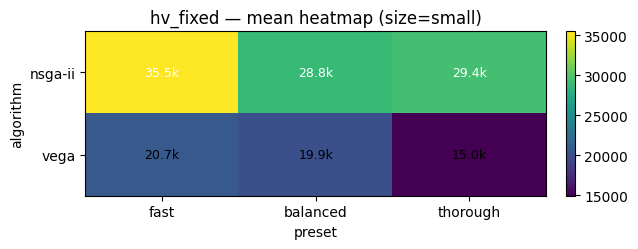

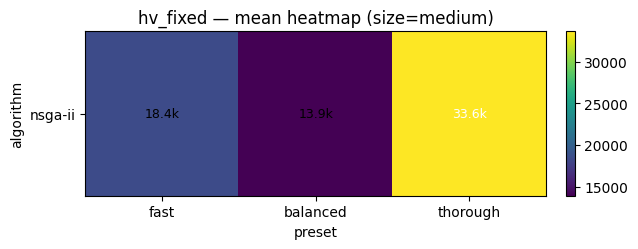

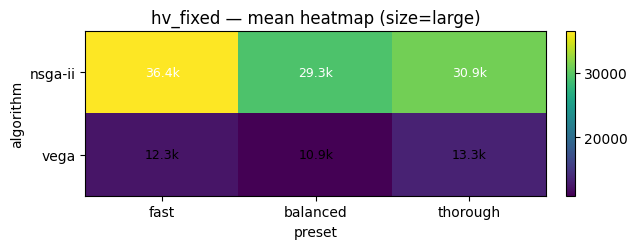

In [79]:

if metrics_nc is None:
    print("metrics_auto*.csv not found — skipping metric plots.")
else:
    # 0) Canonicalize labels like before (reuse ALG_MAP, PRESET_MAP already defined)
    metrics_nc = metrics_nc.copy()
    for col, MAP in (("algorithm", ALG_MAP), ("preset", PRESET_MAP)):
        key = f"__norm_{col}"
        metrics_nc[key] = metrics_nc[col].astype(str).str.lower().str.strip().str.replace(r"[^a-z0-9\-]+","", regex=True)
        metrics_nc[col] = metrics_nc[key].map(MAP).fillna(metrics_nc[col].astype(str).str.lower().str.strip())
        metrics_nc.drop(columns=[key], inplace=True)

    # 1) Attach instance_size from fronts (via instance)
    inst_size_map = _fronts[["instance", "instance_size"]].drop_duplicates()
    metrics_w_size = metrics_nc.merge(inst_size_map, on="instance", how="left")

    # Violin plots per algorithm for each metric/preset/variant
def plot_violin(metrics_w_size, metric_cols):
    preferred_presets = ["fast","balanced","thorough"]
    variants = sorted(metrics_w_size["variant"].unique()) if "variant" in metrics_w_size.columns else ["all"]

    for metric in metric_cols:
        for variant in variants:
            mdf = metrics_w_size if variant=="all" else metrics_w_size[metrics_w_size["variant"]==variant]
            for preset in [p for p in preferred_presets if p in mdf["preset"].unique()]:
                sub = mdf[mdf["preset"]==preset]
                if sub.empty:
                    continue
                algos = sorted(sub["algorithm"].unique())
                data  = [sub.loc[sub["algorithm"]==a, metric].dropna().values for a in algos]
                if not any(len(d) for d in data):
                    continue

                import numpy as np
                fig, ax = plt.subplots(figsize=(7,4.5))
                parts = ax.violinplot([d for d in data if len(d)], showmeans=False, showextrema=False, showmedians=False)
                # x positions of kept violins (skip empties)
                kept_idx = [i+1 for i,d in enumerate(data) if len(d)]
                # median dots
                meds = [np.median(d) for d in data if len(d)]
                ax.plot(kept_idx, meds, marker="o", linestyle="None")

                ax.set_xticks(kept_idx)
                ax.set_xticklabels([a for a,d in zip(algos,data) if len(d)])
                title_variant = f" • variant={variant}" if variant!="all" else ""
                ax.set_title(f"{metric} — violin by algorithm (preset={preset}){title_variant}")
                ax.set_ylabel(metric)
                ax.grid(axis="y", linestyle="--", alpha=0.3)
                plt.tight_layout(); plt.show()

# ECDF per algorithm (one figure per metric/preset/variant)
def plot_ecdf(metrics_w_size, metric_cols):
    preferred_presets = ["fast","balanced","thorough"]
    variants = sorted(metrics_w_size["variant"].unique()) if "variant" in metrics_w_size.columns else ["all"]

    import numpy as np
    for metric in metric_cols:
        for variant in variants:
            mdf = metrics_w_size if variant=="all" else metrics_w_size[metrics_w_size["variant"]==variant]
            for preset in [p for p in preferred_presets if p in mdf["preset"].unique()]:
                sub = mdf[mdf["preset"]==preset]
                if sub.empty:
                    continue
                algos = sorted(sub["algorithm"].unique())
                fig, ax = plt.subplots(figsize=(7,4.5))
                for a in algos:
                    vals = np.sort(sub.loc[sub["algorithm"]==a, metric].dropna().values)
                    if len(vals)==0:
                        continue
                    y = np.arange(1, len(vals)+1)/len(vals)
                    ax.step(vals, y, where="post", label=a)
                ax.set_title(f"{metric} — ECDF (preset={preset}{'' if variant=='all' else ', variant='+variant})")
                ax.set_xlabel(metric); ax.set_ylabel("ECDF")
                ax.grid(True, linestyle="--", alpha=0.3)
                ax.legend(title="Algorithm")
                plt.tight_layout(); plt.show()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# SI formatter up to Exa
def si_fmt(x):
    if x is None or (isinstance(x, float) and (np.isnan(x) or not np.isfinite(x))):
        return "–"
    a = abs(x)
    if a < 1e3:   return f"{x:.0f}"
    if a < 1e6:   return f"{x/1e3:.1f}k"
    if a < 1e9:   return f"{x/1e6:.1f}M"
    if a < 1e12:  return f"{x/1e9:.1f}G"
    if a < 1e15:  return f"{x/1e12:.1f}T"
    if a < 1e18:  return f"{x/1e15:.1f}P"
    return f"{x/1e18:.1f}E"

def si_tick_formatter():
    return FuncFormatter(lambda x, pos: si_fmt(x))

def plot_heatmap_pretty(metrics_w_size, metric,
                        agg="mean",
                        presets=("fast","balanced","thorough"),
                        per_panel_scale=True,
                        trim_percentiles=(0, 100)):  # e.g. (1, 99) to reduce extreme influence
    sizes = [s for s in ["small","medium","large"]
             if s in metrics_w_size["instance_size"].unique()]
    if not sizes:
        print("No instance_size values to plot.")
        return

    for sz in sizes:
        sub = metrics_w_size[metrics_w_size["instance_size"] == sz]
        if sub.empty:
            continue

        algs = sorted(sub["algorithm"].dropna().unique())
        pres = [p for p in presets if p in sub["preset"].unique()]
        if not algs or not pres:
            continue

        M = np.full((len(algs), len(pres)), np.nan)
        for i, a in enumerate(algs):
            for j, p in enumerate(pres):
                vals = sub.loc[(sub["algorithm"]==a) & (sub["preset"]==p), metric].dropna().to_numpy()
                if vals.size:
                    M[i, j] = np.median(vals) if agg == "median" else np.mean(vals)

        # Determine color scale (per panel by default)
        finite = M[np.isfinite(M)]
        if finite.size == 0:
            continue
        lo, hi = np.percentile(finite, trim_percentiles) if trim_percentiles != (0, 100) else (finite.min(), finite.max())
        if not per_panel_scale:
            # global scale across all panels: compute from entire dataset for this metric
            allvals = metrics_w_size[metric].to_numpy()
            allvals = allvals[np.isfinite(allvals)]
            if allvals.size:
                lo, hi = np.percentile(allvals, trim_percentiles) if trim_percentiles != (0, 100) else (allvals.min(), allvals.max())

        # Avoid equal limits
        if hi <= lo:
            hi = lo + 1e-9

        fig_h = max(2.6, 0.5 + 0.45*len(algs))
        fig, ax = plt.subplots(figsize=(6.5, fig_h))

        im = ax.imshow(M, aspect="auto", interpolation="nearest", vmin=lo, vmax=hi)

        ax.set_yticks(np.arange(len(algs))); ax.set_yticklabels(algs)
        ax.set_xticks(np.arange(len(pres))); ax.set_xticklabels(pres)
        ax.set_xlabel("preset"); ax.set_ylabel("algorithm")
        ax.set_title(f"{metric} — {agg} heatmap (size={sz})")

        # Annotate cells with SI formatted numbers; choose text color by background luminance
        def _txt_color(v, lo, hi):
            # normalize 0..1 then simple threshold
            t = 0.0 if hi==lo else (v - lo)/(hi - lo)
            return "white" if t > 0.6 else "black"

        for i in range(len(algs)):
            for j in range(len(pres)):
                v = M[i, j]
                if np.isfinite(v):
                    ax.text(j, i, si_fmt(v), ha="center", va="center",
                            fontsize=9, color=_txt_color(v, lo, hi))

        # Colorbar with SI ticks and NO scientific offset text
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.yaxis.set_major_formatter(si_tick_formatter())
        # This line prevents matplotlib from adding an "×1eN" offset
        cbar.ax.yaxis.offsetText.set_visible(False)
        cbar.update_ticks()

        plt.tight_layout()
        plt.show()

metric_cols = [c for c in ["gd_fixed","igd_fixed","hv_fixed","spread_proxy","spacing","hypervolume"] if c in metrics_w_size.columns]

# plot_violin(metrics_w_size, metric_cols)
# plot_ecdf(metrics_w_size, metric_cols)
# plot_strip(metrics_w_size, metric_cols)


plot_heatmap_pretty(metrics_w_size, metric="hv_fixed", agg="mean",
                    per_panel_scale=True,  trim_percentiles=(0, 100))



50% attainment (median) curves